In [0]:
from datetime import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.models import load_model,Model
from keras.layers import Input,Dense,Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, TensorBoard
import keras.backend as K
from keras.layers.normalization import BatchNormalization

from keras import regularizers
import tensorflow as tf

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
# from sklearn.metrics import precision_recall_fscore_support
# from ml4jets_util import f1_score
from pprint import pprint

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Datasets

In [0]:
path = 'drive/My Drive//Colab Notebooks//datasets//jets//'

df_train = pd.read_csv(path+'train_export_jets.csv',delimiter=',')
df_test = pd.read_csv(path+'test_export_jets.csv',delimiter=',')
df_validation = pd.read_csv(path+'val_export_jets.csv',delimiter=',')

df_train.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df_test.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df_validation.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [0]:
def remove_zero_padded_features(df,padding = 5):
    df_feature_description = df.describe()
    df_filtered = pd.DataFrame()
    indexes = np.array(range(0,df_feature_description.shape[1],padding))

    for ii in indexes:
      cols = df.columns[ii:ii+padding]
      if  np.all(df_feature_description.loc['max',cols] == 0)\
      and np.all(df_feature_description.loc['min',cols] == 0):
        continue
      df_filtered[cols] = df[cols]
    return df_filtered

In [0]:
X_train = remove_zero_padded_features(df_train.drop(labels=['class','njets'],axis=1))
selected_columns = X_train.columns
X_test = df_test[selected_columns]
X_val = df_validation[selected_columns]

y_train = df_train['class'].astype(int).values
y_test = df_test['class'].astype(int).values
y_val = df_validation['class'].astype(int).values

X_train.shape

(5390, 55)

### Separating sets and Pre-processing

In [0]:
X_train_no_anomaly = df_train[df_train['class'] < 1.0][selected_columns].copy()
X_train_anomaly = df_train[df_train['class'] == 1.0][selected_columns].copy()

X_val_no_anomaly = df_validation[df_validation['class'] < 1.0][selected_columns].copy()
X_val_anomaly = df_validation[df_validation['class'] == 1.0][selected_columns].copy()

X_test_no_anomaly = df_test[df_test['class'] < 1.0][selected_columns].copy()
X_test_anomaly = df_test[df_test['class'] == 1.0][selected_columns].copy()

In [0]:
scaler1 = MinMaxScaler(feature_range=(-1,1)).fit(X_train)

X_train_norm_no_anomaly = scaler1.transform(X_train_no_anomaly)
X_val_norm_no_anomaly = scaler1.transform(X_val_no_anomaly)
X_test_norm_no_anomaly = scaler1.transform(X_test_no_anomaly)

# scaler2 = StandardScaler().fit(X_train_anomaly)
# X_train_norm_anomaly = scaler2.transform(X_train_anomaly)
# X_val_norm_anomaly = scaler2.transform(X_val_anomaly)
# X_test_norm_anomaly = scaler2.transform(X_test_anomaly)

X_train_norm = scaler1.transform(X_train)
X_val_norm = scaler1.transform(X_val)
X_test_norm = scaler1.transform(X_test)

### Configuring AE

In [0]:
def build_simple_autoencoder():
  nb_epoch = 500
  batch_size = 32
  input_dim = X_train_norm_no_anomaly.shape[1]
  encoding_dim = 55
  hidden_dim = int(encoding_dim / 2)
  learning_rate = 1e-1

  input_layer = Input(shape=(input_dim, ))

  #encoder
  encoder = Dense(encoding_dim)(input_layer)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  encoder = Dense(hidden_dim)(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  encoder = Dense(int(hidden_dim/2))(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  #decoder
  decoder = Dense(hidden_dim)(encoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='relu')(decoder)

  decoder = Dense(encoding_dim)(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='relu')(decoder)

  decoder = Dense(input_dim)(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='tanh')(decoder)

  autoencoder = Model(inputs=input_layer, outputs=decoder)
  autoencoder.summary()
  return autoencoder

In [0]:
autoencoder = build_simple_autoencoder()
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [0]:
cp = ModelCheckpoint(filepath="autoencoder_classifier_reconstruction.h5",
                               save_best_only=True,
                               verbose=0)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'auto')
start_time = time.time()
print('Starting Training for AutoEncoder...')
history = autoencoder.fit(X_train_norm_no_anomaly, X_train_norm_no_anomaly,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_norm_no_anomaly, X_val_norm_no_anomaly),
                    verbose=1,
                    callbacks=[cp,earlyStopping]).history
print('Total elapsed time:' ,(time.time() - start_time), 'seconds')

Starting Training for AutoEncoder...
Train on 4921 samples, validate on 2117 samples
Epoch 1/500
4921/4921 [==============================] - 4s 757us/step - loss: 0.6290 - acc: 0.0514 - val_loss: 0.2831 - val_acc: 0.0605
Epoch 2/500
4921/4921 [==============================] - 1s 130us/step - loss: 0.3601 - acc: 0.2276 - val_loss: 0.2194 - val_acc: 0.3675
Epoch 3/500
4921/4921 [==============================] - 1s 126us/step - loss: 0.2763 - acc: 0.3044 - val_loss: 0.1580 - val_acc: 0.3888
Epoch 4/500
4921/4921 [==============================] - 1s 130us/step - loss: 0.2269 - acc: 0.3138 - val_loss: 0.1190 - val_acc: 0.4993
Epoch 5/500
4921/4921 [==============================] - 1s 132us/step - loss: 0.1955 - acc: 0.3314 - val_loss: 0.1100 - val_acc: 0.4828
Epoch 6/500
4921/4921 [==============================] - 1s 131us/step - loss: 0.1678 - acc: 0.3432 - val_loss: 0.1154 - val_acc: 0.3259
Epoch 7/500
4921/4921 [==============================] - 1s 131us/step - loss: 0.1674 - acc: 

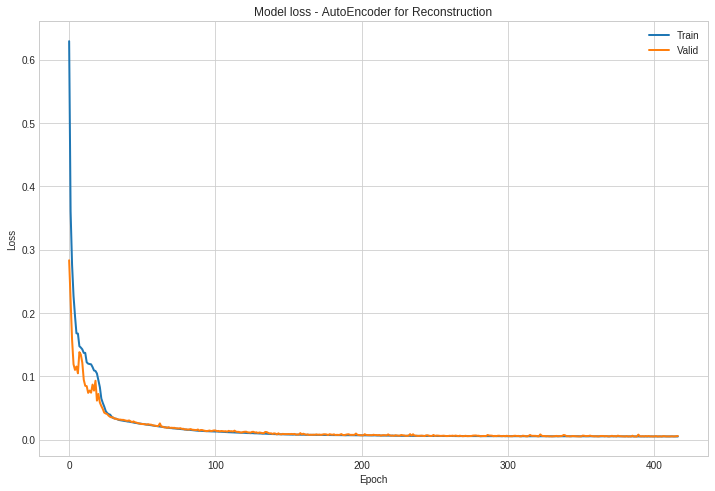

In [0]:
plt.style.use('seaborn-whitegrid')  
plt.figure(figsize=(12, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss - AutoEncoder for Reconstruction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('Model_loss_AutoEncoder_reconstruction.png')
plt.show()

In [0]:
def mean_squared_error(real,prediction):
  return np.mean(((real - prediction)**2), axis=1)

def rmse(real,prediction):
  return np.mean(((real - prediction)**2)**0.5, axis=1)

In [0]:
X_train_no_anomaly_pred = autoencoder.predict(X_train_norm_no_anomaly)

X_train_rmse_array = rmse(X_train_no_anomaly_pred,X_train_norm_no_anomaly)
X_train_rmse = np.mean(X_train_rmse_array)
print('rmse = ',X_train_rmse)
df_train_no_anomaly = pd.DataFrame(X_train_norm_no_anomaly,columns=selected_columns)
display(pd.DataFrame(X_train_norm_no_anomaly,columns=selected_columns).head())
display(pd.DataFrame(X_train_no_anomaly_pred,columns=selected_columns).head())

rmse =  0.030970911799137246


,pt(1),eta(1),phi(1),mass(1),count(1),pt(2),eta(2),phi(2),mass(2),count(2),pt(3),eta(3),phi(3),mass(3),count(3),pt(4),eta(4),phi(4),mass(4),count(4),pt(5),eta(5),phi(5),mass(5),count(5),pt(6),eta(6),phi(6),mass(6),count(6),pt(7),eta(7),phi(7),mass(7),count(7),pt(8),eta(8),phi(8),mass(8),count(8),pt(9),eta(9),phi(9),mass(9),count(9),pt(10),eta(10),phi(10),mass(10),count(10),pt(11),eta(11),phi(11),mass(11),count(11)
0,-0.893593,-0.689094,0.560527,-0.784736,-0.575758,-0.540601,0.169419,-0.447575,-0.739919,-0.600000,-0.639939,-0.388394,-0.241210,-0.830638,-0.686275,-0.798117,0.070333,0.931170,-0.690007,-0.589744,-0.826733,-0.819536,-0.797114,-0.790822,-0.694444,-1.0,-0.027007,0.007554,-1.0,-1.0,-1.0,-0.002364,-0.000192,-1.0,-1.0,-1.0,0.167273,-0.053742,-1.0,-1.0,-1.0,0.629548,0.107023,-1.0,-1.0,-1.0,0.831177,0.831473,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.962373,0.390583,0.085537,-0.526516,-0.666667,-0.492290,-0.046807,-0.907954,-0.807312,-0.481081,-0.945013,-0.783469,0.106070,-0.974302,-0.869281,-0.934619,0.227659,-0.906725,-0.893087,-0.666667,-1.000000,-0.003191,0.000177,-1.000000,-1.000000,-1.0,-0.027007,0.007554,-1.0,-1.0,-1.0,-0.002364,-0.000192,-1.0,-1.0,-1.0,0.167273,-0.053742,-1.0,-1.0,-1.0,0.629548,0.107023,-1.0,-1.0,-1.0,0.831177,0.831473,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.362515,-0.266385,0.487824,-0.456824,-0.131313,0.076592,0.158502,-0.509097,-0.849069,-0.621622,-0.930400,0.611836,0.542500,-0.955624,-0.908497,-1.000000,-0.001576,-0.000302,-1.000000,-1.000000,-1.000000,-0.003191,0.000177,-1.000000,-1.000000,-1.0,-0.027007,0.007554,-1.0,-1.0,-1.0,-0.002364,-0.000192,-1.0,-1.0,-1.0,0.167273,-0.053742,-1.0,-1.0,-1.0,0.629548,0.107023,-1.0,-1.0,-1.0,0.831177,0.831473,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.930051,-0.252916,-0.095865,-0.127483,-0.242424,-0.544247,-0.774822,-0.972864,-0.865350,-0.643243,-0.263331,0.195928,0.607959,-0.848063,-0.607843,-0.781611,0.322307,-0.786263,-0.709406,-0.384615,-0.831397,-0.297268,0.404915,-0.758151,-0.666667,-1.0,-0.027007,0.007554,-1.0,-1.0,-1.0,-0.002364,-0.000192,-1.0,-1.0,-1.0,0.167273,-0.053742,-1.0,-1.0,-1.0,0.629548,0.107023,-1.0,-1.0,-1.0,0.831177,0.831473,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.375856,-0.312115,-0.050736,0.342283,-0.232323,0.050189,0.672881,0.948304,-0.493810,-0.351351,-0.966916,-0.679062,0.635154,-0.984805,-0.921569,-1.000000,-0.001576,-0.000302,-1.000000,-1.000000,-1.000000,-0.003191,0.000177,-1.000000,-1.000000,-1.0,-0.027007,0.007554,-1.0,-1.0,-1.0,-0.002364,-0.000192,-1.0,-1.0,-1.0,0.167273,-0.053742,-1.0,-1.0,-1.0,0.629548,0.107023,-1.0,-1.0,-1.0,0.831177,0.831473,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


,pt(1),eta(1),phi(1),mass(1),count(1),pt(2),eta(2),phi(2),mass(2),count(2),pt(3),eta(3),phi(3),mass(3),count(3),pt(4),eta(4),phi(4),mass(4),count(4),pt(5),eta(5),phi(5),mass(5),count(5),pt(6),eta(6),phi(6),mass(6),count(6),pt(7),eta(7),phi(7),mass(7),count(7),pt(8),eta(8),phi(8),mass(8),count(8),pt(9),eta(9),phi(9),mass(9),count(9),pt(10),eta(10),phi(10),mass(10),count(10),pt(11),eta(11),phi(11),mass(11),count(11)
0,-0.857122,-0.639199,0.368786,-0.781475,-0.570229,-0.437215,0.158563,-0.533167,-0.771910,-0.596039,-0.698031,-0.168924,-0.246871,-0.825569,-0.596994,-0.869965,0.107804,0.836222,-0.895881,-0.698295,-0.874179,-0.605307,-0.688080,-0.877266,-0.754856,-0.985784,0.055498,0.032405,-0.979064,-0.971327,-0.997395,-0.015182,0.014613,-0.997395,-0.997516,-0.997377,0.162807,-0.051582,-0.997678,-0.997401,-0.999866,0.627715,0.111961,-0.999963,-0.999672,-0.999575,0.832056,0.814769,-0.996406,-0.993166,-0.999882,-1.000000,-0.999999,-0.999826,-0.999877
1,-0.909576,0.282563,-0.042180,-0.649423,-0.596732,-0.422873,-0.076163,-0.958718,-0.739798,-0.514565,-0.939044,-0.611774,0.048695,-0.944855,-0.821952,-0.920280,0.222671,-0.861584,-0.950455,-0.762166,-0.991699,0.017927,0.013734,-0.991038,-0.986324,-0.991754,-0.015530,-0.040308,-0.984116,-0.986778,-0.997036,-0.004149,0.002713,-0.997003,-0.996839,-0.997584,0.164173,-0.053245,-0.998356,-0.997712,-0.999221,0.629226,0.110434,-0.999440,-0.999939,-0.999999,0.829351,0.823498,-0.999998,-0.999999,-1.000000,-0.998338,-0.998738,-1.000000,-1.000000
2,-0.385025,-0.349380,0.336339,-0.482632,-0.294013,0.041394,0.117675,-0.611155,-0.813486,-0.591781,-0.935171,0.519409,0.406516,-0.948029,-0.827354,-0.999104,-0.035390,-0.022703,-0.998623,-0.995480,-0.999825,0.008686,-0.017073,-0.999898,-0.999753,-0.999985,-0.006165,-0.044511,-0.999954,-0.999927,-0.999979,-0.006218,0.005186,-0.999975,-0.999972,-0.999911,0.156833,-0.052853,-0.999940,-0.999801,-0.999655,0.631758,0.106595,-0.999912,-0.999971,-0.999626,0.825659,0.823644,-0.999676,-0.999713,-0.999554,-0.999252,-0.999462,-0.999307,-0.999437
3,-0.870587,-0.262395,-0.130579,-0.437965,-0.191678,-0.492127,-0.655595,-0.979577,-0.830125,-0.666746,-0.457386,0.110101,0.511420,-0.728260,-0.462433,-0.738734,0.286456,-0.683916,-0.794281,-0.489896,-0.851894,-0.207178,0.424621,-0.865859,-0.718759,-0.990836,0.013884,-0.049918,-0.985869,-0.981829,-0.997908,-0.012206,-0.007969,-0.996794,-0.998186,-0.997835,0.162125,-0.049046,-0.998223,-0.997392,-0.999757,0.631206,0.108790,-0.999877,-0.999531,-0.999960,0.830221,0.824932,-0.999822,-0.999463,-0.999720,-0.999922,-0.999990,-0.999840,-0.999865
4,-0.434925,-0.309897,-0.136859,0.187049,-0.295854,-0.001528,0.559360,0.874481,-0.592189,-0.348709,-0.908191,-0.556015,0.528442,-0.977554,-0.904746,-0.999300,-0.036908,0.002092,-0.999141,-0.998277,-0.999910,0.022957,-0.030130,-0.999946,-0.999820,-0.999990,0.013091,-0.032522,-0.999979,-0.999970,-0.999975,0.000343,0.003129,-0.999976,-0.999977,-0.999973,0.154238,-0.048784,-0.999982,-0.999966,-0.999352,0.631306,0.104387,-0.999993,-0.999993,-0.998889,0.823721,0.824333,-0.999676,-0.999384,-0.999346,-0.999140,-0.999557,-0.999401,-0.999577


In [0]:
X_train_rmse_array.min()

0.010854999165933988

In [0]:

X_predictions = autoencoder.predict(X_val_norm)
mse = mean_squared_error(X_val_norm, X_predictions)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
                        # 'True_class': y_train[y_train < 1.0]})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

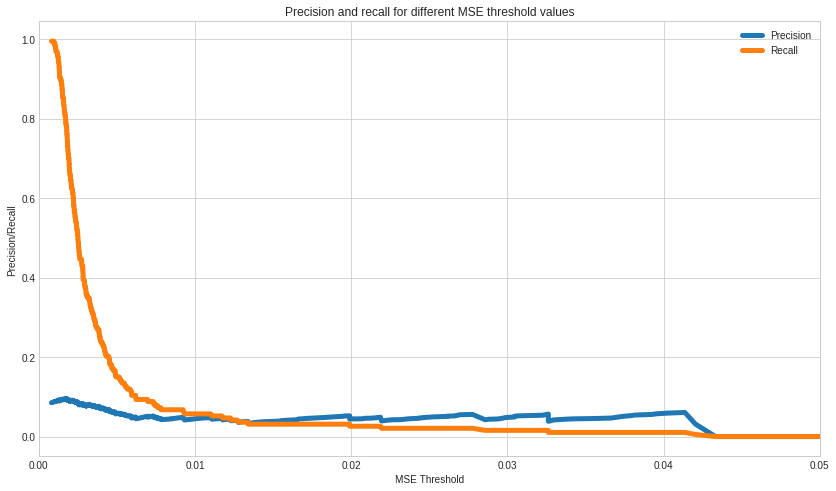

In [0]:
plt.style.use('seaborn-whitegrid')  
plt.figure(figsize=(14,8))
plt.plot(threshold_rt[:-1], precision_rt[1:-1], label="Precision",linewidth=5)
plt.plot(threshold_rt[:-1], recall_rt[1:-1], label="Recall",linewidth=5)
plt.title('Precision and recall for different MSE threshold values')
plt.xlabel('MSE Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.xlim(0,0.05)
plt.grid(True)
# plt.savefig('Precision_Recall_AutoEncoder_reconstruction.png')

In [0]:
X_test_pred = autoencoder.predict(X_test_norm)
y_pred_class = mean_squared_error(X_test_pred, X_test_norm).ravel()

threshold = 0.005
y_pred_class[y_pred_class > threshold] = 1
y_pred_class[y_pred_class <= threshold] = 0

### Results

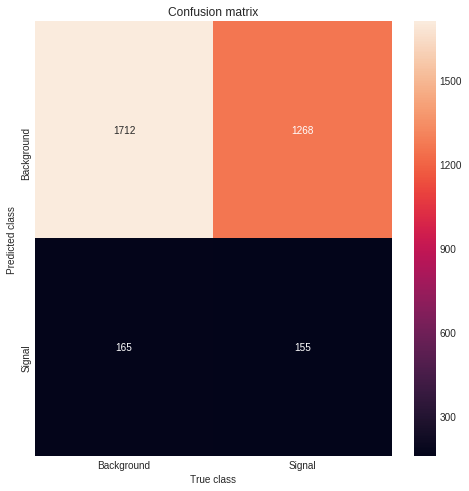

In [0]:
 df_prediction = pd.DataFrame({'Predicted': y_pred_class.ravel(),
                        'True_class': y_test.ravel()})

LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

In [0]:
target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names = target_names)
print(c)

              precision    recall  f1-score   support

  Background       0.91      0.57      0.70      2980
      Signal       0.11      0.48      0.18       320

    accuracy                           0.57      3300
   macro avg       0.51      0.53      0.44      3300
weighted avg       0.83      0.57      0.65      3300

